In [1]:
from pyoxigraph import *
from sklearn.covariance import OAS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from utils import *
from Ressources import *
from Ontology import *
from decomposition import *
from pprint import pprint

/home/sam/github/EmbedAlign/embed/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [12]:
def embed_label(target_phrase, sentence):
    
    encoded = tokenizer(sentence, return_tensors="pt", add_special_tokens=False)
    sent_tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
    target_tokens = tokenizer.tokenize(target_phrase)
    target_positions = []
    for i in range(len(sent_tokens) - len(target_tokens) + 1):
        if sent_tokens[i : i + len(target_tokens)] == target_tokens:
            target_positions.extend(range(i, i + len(target_tokens)))
    if len(target_positions) == 0:
        raise ValueError(f"Phrase '{target_phrase}' not found in tokenized sentence.")
    with torch.no_grad():
        outputs = model(**encoded)
    hidden = outputs.last_hidden_state
    word_embedding = hidden[0, target_positions, :].mean(dim=0)

    return word_embedding

def oas(word, sentences):
    embeddings = [embed_label(word, s) for s in sentences]
    stacked = torch.stack(embeddings)
    data = np.array(embeddings)
    oas = OAS()
    return stacked, oas.fit(data)

def fit_pca(oas : OAS):
    var = oas.covariance_
    var_t = torch.from_numpy(var).float()
    M, D, V = torch.linalg.svd(var_t)
    return V[:2].T.cpu().numpy()

def project_mean_and_cov(mu: torch.Tensor, cov: torch.Tensor, W: torch.Tensor):
    mu_2d = W.T @ mu
    cov_2d = W.T @ cov @ W
    return mu_2d, cov_2d

def get_ellipsis(word : str, sentences : list):
    embeddings, oac = oas(word, sentences)
    mean = embeddings.mean(dim=0).cpu().numpy()
    pca = fit_pca(oac)
    return project_mean_and_cov(mean, oac.covariance_, pca)

def covariance_to_ellipse_params(cov_2d: torch.Tensor, n_std=1.0):
    eigvals, eigvecs = torch.linalg.eigh(cov_2d)
    idx = torch.argsort(eigvals, descending=True)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    width, height = 2 * n_std * torch.sqrt(eigvals)
    angle = torch.atan2(eigvecs[1, 0], eigvecs[0, 0]) * (180.0 / torch.pi)
    return width.item(), height.item(), angle.item()


def plot_region(mu_2d, cov_2d, label=None, n_std=1.0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    width, height, angle = covariance_to_ellipse_params(torch.from_numpy(cov_2d), n_std)
    ellipse = Ellipse(
        xy=mu_2d,
        width=width,
        height=height,
        angle=angle,
        edgecolor='blue',
        facecolor = "none",
        alpha=0.4
    )
    ax.add_patch(ellipse)
    ax.scatter(mu_2d[0], mu_2d[1], c='red', s=30)
    if label:
        ax.text(mu_2d[0], mu_2d[1], f" {label}", fontsize=12)
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    return ax

## Initialisation

In [4]:
file = "../test/bfo-core.ttl"
bfo = Ontology.load(file)
hierarchy = bfo.format_hierarchy()
pprint(hierarchy)

{'http://purl.obolibrary.org/obo/BFO_0000001': ['http://purl.obolibrary.org/obo/BFO_0000003',
                                                'http://purl.obolibrary.org/obo/BFO_0000002'],
 'http://purl.obolibrary.org/obo/BFO_0000002': ['http://purl.obolibrary.org/obo/BFO_0000031',
                                                'http://purl.obolibrary.org/obo/BFO_0000020',
                                                'http://purl.obolibrary.org/obo/BFO_0000004'],
 'http://purl.obolibrary.org/obo/BFO_0000003': ['http://purl.obolibrary.org/obo/BFO_0000035',
                                                'http://purl.obolibrary.org/obo/BFO_0000015',
                                                'http://purl.obolibrary.org/obo/BFO_0000011',
                                                'http://purl.obolibrary.org/obo/BFO_0000008'],
 'http://purl.obolibrary.org/obo/BFO_0000004': ['http://purl.obolibrary.org/obo/BFO_0000141',
                                                'http://p

[]

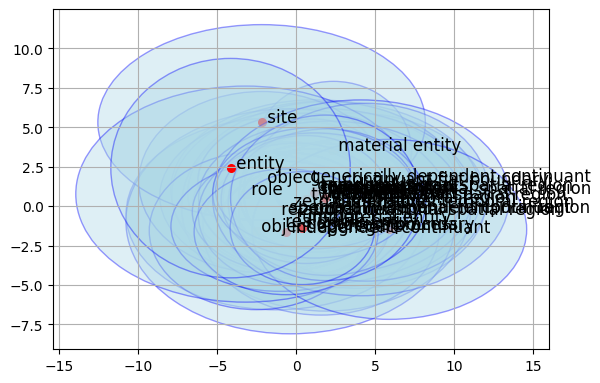

In [5]:
figs, axs = plt.subplots()
ellipsis_dict = {}
disjoint_pairs = []
for c in bfo.named_classes:
    for d in c.disjoints:
        disjoint_pairs.append((c.iri, d.iri))
    label, sentences = c.create_sentences()
    center, cov = get_ellipsis(label, sentences)
    ellipsis_dict[c.iri] = center, cov
    plot_region(center, cov, label=str(c), n_std=2.0, ax=axs)
plt.plot()

## Optimization

In [6]:
optimized = optimize_hierarchy(ellipsis_dict,  bfo.format_hierarchy(), disjoint_pairs, lr = 2e-2, target_loss=0.01)

/home/sam/github/EmbedAlign/src/decomposition.py:123: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  Q22 = (mu1.T @ A1 @ mu1 + lam * mu2.T @ A2 @ mu2 - (1 + lam))  # scalar


[step 200] loss = 24.4853
[step 400] loss = 18.9906
[step 600] loss = 16.5382
[step 800] loss = 14.6022
[step 1000] loss = 13.2932
[step 1200] loss = 12.2716
[step 1400] loss = 11.3904
[step 1600] loss = 10.6514
[step 1800] loss = 10.0327
[step 2000] loss = 9.5115
[step 2200] loss = 9.0789
[step 2400] loss = 8.7111
[step 2600] loss = 8.3860
[step 2800] loss = 8.0907
[step 3000] loss = 7.8192
[step 3200] loss = 7.5675
[step 3400] loss = 7.3342
[step 3600] loss = 7.1188
[step 3800] loss = 6.9206
[step 4000] loss = 6.7404
[step 4200] loss = 6.5768
[step 4400] loss = 6.4292
[step 4600] loss = 6.2960
[step 4800] loss = 6.1773
[step 5000] loss = 6.0714
[step 5200] loss = 5.9766
[step 5400] loss = 5.8914
[step 5600] loss = 5.8144
[step 5800] loss = 5.7444
[step 6000] loss = 5.6802
[step 6200] loss = 5.6201
[step 6400] loss = 5.5607
[step 6600] loss = 5.4867
[step 6800] loss = 5.0313
[step 7000] loss = 4.5064
[step 7200] loss = 4.4169
[step 7400] loss = 4.2636
[step 7600] loss = 3.3130
[step 7

 mu : [0.95150566 0.67707604]
 mu : [1.1384149  0.05366472]
 mu : [1.1159396  0.27051738]
 mu : [0.9888611 0.6368882]
 mu : [-0.95257074 -0.21003565]
 mu : [-0.99924856 -0.11371593]
 mu : [-0.8330398 -0.2356631]
 mu : [-0.90849215 -0.17126219]
 mu : [-0.97592604 -0.07099668]
 mu : [-0.99606043 -0.16102913]
 mu : [-1.007771   0.6643849]
 mu : [1.1341252  0.08607249]
 mu : [1.0413148  0.27585533]
 mu : [-1.0759667  0.982208 ]
 mu : [-1.3484561   0.16175267]
 mu : [-1.002838   0.7778228]
 mu : [-1.0273684  -0.16204703]
 mu : [-1.0459857  -0.20419733]
 mu : [-0.9635483   0.75954807]
 mu : [-1.0567182  -0.23377897]
 mu : [-0.9948894  0.7033474]
 mu : [-1.1746161  0.6618192]
 mu : [-1.018108   0.3481294]
 mu : [-0.85807174 -0.19053829]
 mu : [-0.96167123 -0.19837527]
 mu : [-1.0653739   0.70860475]
 mu : [-1.0563762  0.9683444]
 mu : [1.0276493  0.27927682]
 mu : [0.8299593  0.33312106]
 mu : [-0.8217263 -0.2988318]
 mu : [1.021515   0.36715785]
 mu : [-0.9313972  -0.19370879]
 mu : [-0.9885

[]

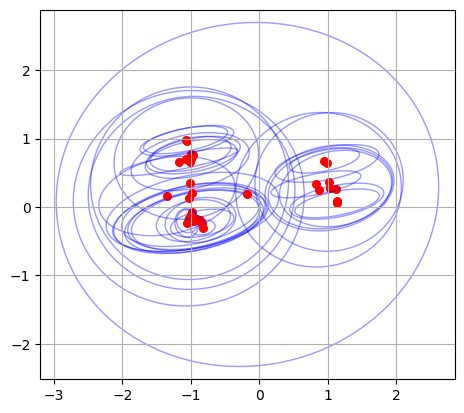

In [13]:
figs, axs = plt.subplots()
for o in optimized.values():
    mu_2d = o.mu.detach().cpu().numpy()
    cov_2d = o.cov().detach().cpu().numpy()
    print(f" mu : {mu_2d}")
    plot_region(mu_2d, cov_2d,  n_std=2.0, ax=axs)
plt.plot()